In [1]:
import os
import sys
import pandas as pd
import numpy as np
import datetime  
import time
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
from torchsummary import summary
from utils.dataset import *
from typing import List
from torch.nn import functional as F
from scipy.stats import entropy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
pairs = 1000
pairdata, freqpairs, n_size, n_interval = get_univ_data(pairs)
sizedata = get_data(pairdata, freqpairs, 'size_index', n_size)
size_cdf = pd.read_csv('data/univ/size_cdf.csv')
# size_cdf = pd.read_csv('data/fb/size_cdf.csv')
size_cdf = np.concatenate(([0], (size_cdf['size'].values[1:] + size_cdf['size'].values[:-1]) / 2))
mean_sizes = (sizedata * size_cdf).sum(axis=1)

In [4]:
class SizeEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(SizeEncoder, self).__init__()
        self.encoder = nn.ModuleList()
        in_dim = input_dim 
        for h_dim in hidden_dims:
            self.encoder.append(
                nn.Sequential(
                    nn.Linear(in_dim, out_features=h_dim),
                    nn.ReLU())
            )
            in_dim = h_dim
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)
    
    def forward(self, x: Tensor) -> List[Tensor]:
        for module in self.encoder:
            x = module(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return [mu, log_var]

class SizeDecoder(torch.nn.Module):
    def __init__(self, output_dim, hidden_dims, latent_dim):
        super(SizeDecoder, self).__init__()
        self.decoder = torch.nn.ModuleList()
        in_dim = latent_dim
        for h_dim in hidden_dims:
            self.decoder.append(
                nn.Sequential(
                    nn.Linear(in_dim, out_features=h_dim,),
                    nn.ReLU())
            )
            in_dim = h_dim
        self.output = nn.Linear(hidden_dims[-1], output_dim)
    
    def forward(self, x: Tensor) -> List[Tensor]:
        for module in self.decoder:
            x = module(x)
        result = self.output(x)
        result = F.softmax(result, dim=1)
        return result

In [5]:
def reparameterize(mu: Tensor, logvar: Tensor) -> Tensor:
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps * std + mu

def train(encoder, decoder, dataloader, optimizer):
    epoch_loss, epoch_kld, epoch_recon, epoch_size, sample_num = 0, 0, 0, 0, 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        mu, var = encoder(data)
        z = reparameterize(mu, var)
        y = decoder(z)
        recon_loss = F.l1_loss(y, data)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + var - mu ** 2 - var.exp(), dim = 1), dim = 0)
        loss = recon_loss + kld_weight * kld_loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(data)
        epoch_kld += kld_loss.item() * len(data)
        epoch_recon += recon_loss.item() * len(data)
        sample_num += len(data)

    epoch_loss /= sample_num
    epoch_recon /= sample_num
    epoch_kld /= sample_num
    epoch_size /= sample_num
    return epoch_loss, epoch_recon, epoch_kld, epoch_size

kld_weight = 1e-5

In [6]:
def cramer_dis(x, y):
    cdf_x = np.cumsum(x)
    cdf_y = np.cumsum(y)
    return np.sum(np.abs(cdf_x - cdf_y)) / x.shape[0]

def js_dis(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

def model_test(encoder, decoder):
    size_dis = []
    mean_size_dis = []
    for i in range(pairs):
        size_data = sizedata[i]
        size_data = torch.tensor(size_data, dtype=torch.float).to(device).unsqueeze(0)
        mu, var = encoder(size_data)
        z = reparameterize(mu, var)
        new_size = decoder(z)
        new_size = new_size.cpu().detach().numpy().squeeze()
        new_size[new_size < 1e-3] = 0
        new_size /= new_size.sum()
        new_mean_size = (new_size * size_cdf).sum()
        size_dis.append(js_dis(new_size, sizedata[i]))
        mean_size_dis.append(np.abs(new_mean_size - mean_sizes[i]) / mean_sizes[i])
    return np.mean(size_dis), mean_size_dis

In [7]:
latent_dim = 32
hidden_dims = [64, 128, 256, 128, 64]
encoder = SizeEncoder(n_size, hidden_dims, latent_dim).to(device)
hidden_dims.reverse()
decoder = SizeDecoder(n_size, hidden_dims, latent_dim).to(device)
print('encoder:', summary(encoder, [[n_size]]))
print('decoder:', summary(decoder, [[latent_dim]]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,984
              ReLU-2                   [-1, 64]               0
            Linear-3                  [-1, 128]           8,320
              ReLU-4                  [-1, 128]               0
            Linear-5                  [-1, 256]          33,024
              ReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 32]           2,080
           Linear-12                   [-1, 32]           2,080
Total params: 88,640
Trainable params: 88,640
Non-trainable params: 0
---------------------------------

In [8]:
date = 'univ-2023-6-6-23'
model_name = '1000000'
encoder = torch.load('model/{date}/encoder-{name}.pth'.format(date=date, name=model_name))
decoder = torch.load('model/{date}/decoder-{name}.pth'.format(date=date, name=model_name))

In [86]:
dataset = torch.tensor(sizedata, dtype=torch.float)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)
lr = 1e-3
optimizer = torch.optim.Adam([{'params': encoder.parameters()}, {'params': decoder.parameters()}], lr=lr)

In [88]:
from tqdm import tqdm
def get_dis(decoder, latent_dim, sizedata, pairs):
    size_dis = np.zeros((pairs, pairs))
    decoder.eval()
    mean_sizes = []
    for i in range(pairs):
        z = torch.randn((1, latent_dim)).to(device)
        size = decoder(z)
        size = size.squeeze().detach().to('cpu').numpy()
        size[size < 1e-3] = 0
        size /= size.sum()
        mean_size = (size * size_cdf).sum()
        mean_sizes.append(mean_size)
        for j in range(pairs):
            loss = cramer_dis(size, sizedata[j:j+1])
            size_dis[i][j] = loss
    return size_dis, mean_sizes

In [89]:
stop_loss = 1e-3
encoder.train()
decoder.train()
start_time = time.time()
min_epoch_loss = 100
for epoch in range(100001):
    epoch_loss, epoch_recon, epoch_kld, epoch_size = train(encoder, decoder, dataloader, optimizer)
    min_epoch_loss = min(epoch_loss, min_epoch_loss)
    if epoch and epoch % 100 == 0:
        size_dis, mean_size_dis = model_test(encoder, decoder)
        cur_time = time.time()
        print("epoch=%d, loss=%.2e, min_loss=%.2e, kld=%.2f, recon=%.2e, size=%.2e, size_dis=%.3f, mean_size=%.2f, max_size=%.2f(%d), time=%.2f" % (epoch, epoch_loss, min_epoch_loss, epoch_kld, epoch_recon, epoch_size, size_dis, np.mean(mean_size_dis), np.max(mean_size_dis), np.argmax(mean_size_dis), cur_time - start_time))
        min_epoch_loss = 100

    if epoch and epoch % 10000 == 0:
        size_dis, pred_mean_sizes = get_dis(decoder, latent_dim, sizedata[:pairs], pairs)
        print("%d, %d, %.2e, %.2e, %.2e, %.2e, %.2e, %.2e, %.2e, %.2e" % (np.mean(pred_mean_sizes), np.mean(mean_sizes), np.sort(np.min(size_dis, axis=0))[-100], np.sort(np.min(size_dis, axis=0))[-50], np.sort(np.min(size_dis, axis=0))[-10], np.sort(np.min(size_dis, axis=0))[-1], np.sort(np.min(size_dis, axis=1))[-100], np.sort(np.min(size_dis, axis=1))[-50], np.sort(np.min(size_dis, axis=1))[-10], np.sort(np.min(size_dis, axis=1))[-1]))
    if epoch_loss < stop_loss:
        size_dis, mean_size_dis = model_test(encoder, decoder)
        print("epoch=%d, loss=%.2e, min_loss=%.2e, kld=%.2f, recon=%.2e, size=%.2e, size_dis=%.3f, mean_size=%.2f, max_size=%.2f(%d), time=%.2f" % (epoch, epoch_loss, min_epoch_loss, epoch_kld, epoch_recon, epoch_size, size_dis, np.mean(mean_size_dis), np.max(mean_size_dis), np.argmax(mean_size_dis), cur_time - start_time))
        size_dis, pred_mean_sizes = get_dis(decoder, latent_dim, sizedata[:pairs], pairs)
        print("%d, %d, %.2e, %.2e, %.2e, %.2e, %.2e, %.2e, %.2e, %.2e" % (np.mean(pred_mean_sizes), np.mean(mean_sizes), np.sort(np.min(size_dis, axis=0))[-100], np.sort(np.min(size_dis, axis=0))[-50], np.sort(np.min(size_dis, axis=0))[-10], np.sort(np.min(size_dis, axis=0))[-1], np.sort(np.min(size_dis, axis=1))[-100], np.sort(np.min(size_dis, axis=1))[-50], np.sort(np.min(size_dis, axis=1))[-10], np.sort(np.min(size_dis, axis=1))[-1]))
        break

epoch=100, loss=6.02e-03, min_loss=6.01e-03, kld=2.82, recon=5.74e-03, size=0.00e+00, size_dis=0.013, mean_size=0.11, max_size=4.79(5273), time=21.27
epoch=200, loss=5.99e-03, min_loss=5.95e-03, kld=2.96, recon=5.70e-03, size=0.00e+00, size_dis=0.013, mean_size=0.10, max_size=4.67(3741), time=42.29
epoch=300, loss=5.97e-03, min_loss=5.92e-03, kld=2.87, recon=5.68e-03, size=0.00e+00, size_dis=0.013, mean_size=0.10, max_size=4.99(5273), time=63.67
epoch=400, loss=5.92e-03, min_loss=5.90e-03, kld=2.98, recon=5.62e-03, size=0.00e+00, size_dis=0.013, mean_size=0.10, max_size=4.88(5273), time=83.90
epoch=500, loss=5.90e-03, min_loss=5.89e-03, kld=2.93, recon=5.60e-03, size=0.00e+00, size_dis=0.013, mean_size=0.11, max_size=4.98(5273), time=108.35


KeyboardInterrupt: 

In [9]:
from tqdm import tqdm
def cramer_dis(x, y):
    cdf_x = np.cumsum(x)
    cdf_y = np.cumsum(y)
    return np.sum(np.abs(cdf_x - cdf_y)) / x.shape[0]


def get_dis(decoder, latent_dim, data, pairs):
    dis = np.zeros((pairs, pairs))
    decoder.eval()
    for i in tqdm(range(pairs)):
        z = torch.randn((1, latent_dim)).to(device)
        y = decoder(z)
        y = y.squeeze().detach().to('cpu').numpy()
        for j in range(pairs):
            loss = cramer_dis(y, data[j:j+1])
            dis[i][j] = loss
    return dis

def test_vae(date, model_name, latent_dim, data, pairs):
    decoder = torch.load('models/{date}/decoder-{name}.pth'.format(date=date, name=model_name))
    summary(decoder, [[latent_dim]], device='cuda')
    dis = get_dis(decoder, latent_dim, data, pairs)
    accuracy = np.min(dis, axis=1)
    coverage = np.min(dis, axis=0)
    return accuracy, coverage

dis = get_dis(decoder, latent_dim, sizedata, pairs)
accuracy = np.min(dis, axis=1)
coverage = np.min(dis, axis=0)

100%|██████████| 1000/1000 [00:13<00:00, 72.92it/s]


In [10]:
all_size = []
for i in range(pairs):
    all_size.extend(list(pairdata[freqpairs[i]]['size_index'].values))
values, counts = np.unique(all_size, return_counts=True)
all_size = np.zeros(n_size, dtype=float)
all_size[values] = counts
all_size /= all_size.sum()

he_dis = []
for i in range(pairs):
    he_dis.append(cramer_dis(all_size, sizedata[i]))

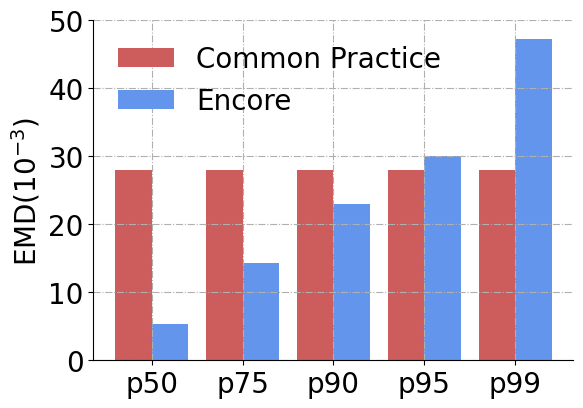

In [41]:
import matplotlib.pyplot as plt
acc_percentile = np.percentile(accuracy, [50, 75, 90, 95, 99])
plt.figure(figsize=(6, 4))
plt.subplots_adjust(left=0.18, top=0.95, bottom=0.1, right=0.98)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.bar(np.arange(5) * 2, np.min(he_dis), width=0.8, label='Common Practice', color='IndianRed')
plt.bar(np.arange(5) * 2 + 0.8, acc_percentile, width=0.8, label='Encore', color='CornFlowerBlue')

plt.legend(fontsize=20, frameon=False)
plt.xticks(np.arange(5) * 2 + 0.4, ['p50', 'p75', 'p90', 'p95', 'p99'], fontsize=20)
plt.yticks(np.arange(0, 0.051, 0.01), np.arange(0, 51, 10), fontsize=20)
plt.ylabel('EMD($10^{-3}$)', fontsize=20)
plt.grid(linestyle='-.')
plt.savefig('figure/univ-accuracy.pdf', dpi=400)

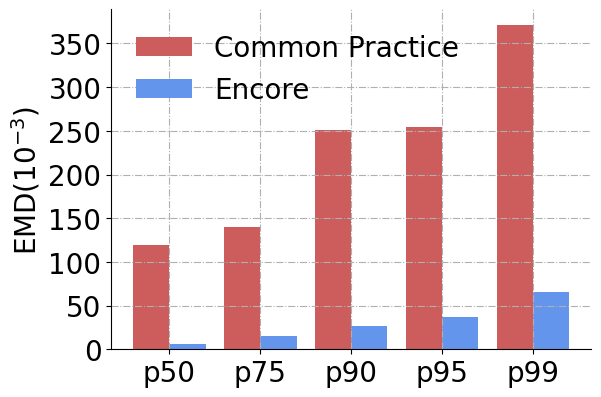

In [40]:
import matplotlib.pyplot as plt
cov_percentile = np.percentile(coverage, [50, 75, 90, 95, 99])
he_percentile = np.percentile(he_dis, [50, 75, 90, 95, 99])
plt.figure(figsize=(6, 4))
plt.subplots_adjust(left=0.18, top=0.95, bottom=0.1, right=0.98)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.bar(np.arange(5) * 2, he_percentile, width=0.8, label='Common Practice', color='IndianRed')
plt.bar(np.arange(5) * 2 + 0.8, cov_percentile, width=0.8, label='Encore', color='CornFlowerBlue')
plt.legend(fontsize=20, frameon=False)
plt.xticks(np.arange(5) * 2 + 0.4, ['p50', 'p75', 'p90', 'p95', 'p99'], fontsize=20)
plt.yticks(np.arange(0, 0.351, 0.05), np.arange(0, 351, 50), fontsize=20)
plt.ylabel('EMD($10^{-3}$)', fontsize=20)
plt.grid(linestyle='-.')
plt.savefig('figure/univ-coverage.pdf', dpi=400)

In [94]:
acc_percentile

array([0.00582496, 0.01466801, 0.02376945, 0.03169917, 0.04509721])

In [27]:
print(np.median(accuracy), np.percentile(accuracy, 90), np.percentile(accuracy, 95), np.percentile(accuracy, 99))
print(np.median(coverage), np.percentile(coverage, 90), np.percentile(coverage, 95), np.percentile(coverage, 99))
print(np.median(he_dis), np.percentile(he_dis, 90), np.percentile(he_dis, 95), np.percentile(he_dis, 99))

0.005902104859066849 0.023505440567998002 0.028134902930210866 0.04402239070113206
0.005548271731673729 0.023546688105518875 0.03366673031000891 0.059560134400733114
0.11906019006390729 0.2508208955606096 0.25394341267956827 0.37056898211298345


In [21]:
print(np.median(accuracy), np.sort(accuracy)[-100], np.sort(accuracy)[-50], np.sort(accuracy)[-10])
print(np.median(coverage), np.sort(coverage)[-100], np.sort(coverage)[-50], np.sort(coverage)[-10])
print(np.median(he_dis), np.sort(he_dis)[-100], np.sort(he_dis)[-50], np.sort(he_dis)[-10])

0.01860408887671437 0.03484575889757981 0.04150098704752357 0.05441737175576946
0.008716100911641638 0.026429096039522575 0.03352766144379293 0.05669997597165539
0.11906019006390729 0.25085738081448616 0.25548791165216583 0.37250936637636556


In [22]:
np.min(he_dis)

0.028052353414491523

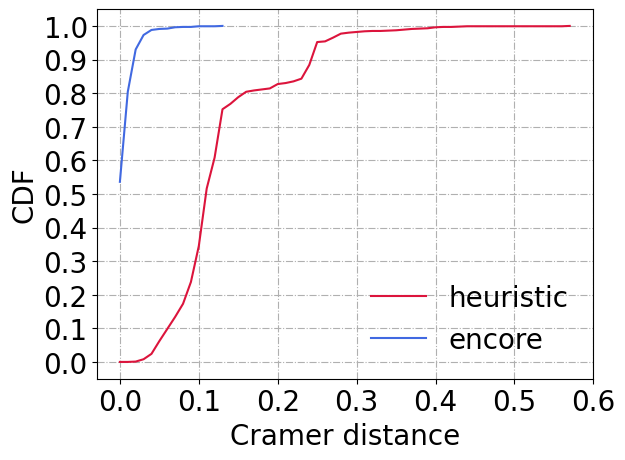

In [23]:
import matplotlib.pyplot as plt
values, bins = np.histogram(he_dis, bins=np.arange(0, np.max(he_dis) + 0.01, 0.01))
cdf = np.cumsum(values) / values.sum()
plt.plot(bins[:-1], cdf, color='crimson', label='heuristic')

encore_dis = coverage
values, bins = np.histogram(encore_dis, bins=np.arange(0, np.max(encore_dis) + 0.01, 0.01))
cdf = np.cumsum(values) / values.sum()
plt.plot(bins[:-1], cdf, color='royalblue', label='encore')

plt.xticks(np.arange(0, 0.7, 0.1), fontsize=20)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.xlabel('Cramer distance', fontsize=20)
plt.grid(linestyle='-.')
plt.legend(fontsize=20, frameon=False)

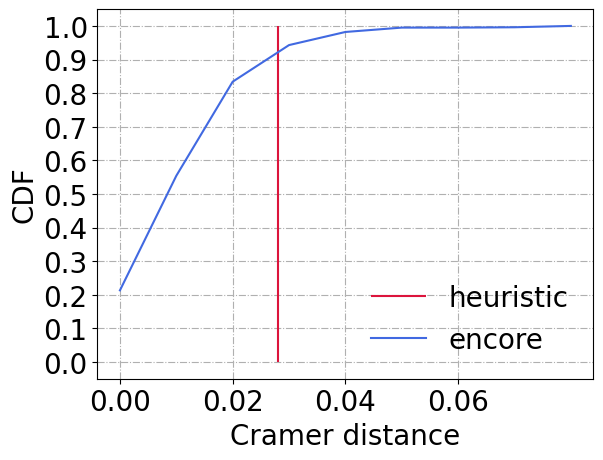

In [24]:
# values, bins = np.histogram(np.min(he_dis), bins=np.arange(np.min(he_dis), np.min(he_dis) + 0.01, 0.01))
# cdf = np.cumsum(values) / values.sum()
# plt.plot(bins[:-1], cdf, color='crimson', label='heuristic')
plt.vlines(np.min(he_dis), 0, 1, color='crimson', label='heuristic')

encore_dis = accuracy
values, bins = np.histogram(encore_dis, bins=np.arange(0, np.max(encore_dis) + 0.01, 0.01))
cdf = np.cumsum(values) / values.sum()
plt.plot(bins[:-1], cdf, color='royalblue', label='encore')

plt.xticks(np.arange(0, 0.07, 0.02), fontsize=20)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.xlabel('Cramer distance', fontsize=20)
plt.grid(linestyle='-.')
plt.legend(fontsize=20, frameon=False, loc='lower right')
# plt.savefig('results/size_accuracy.png', bbox_inches='tight')

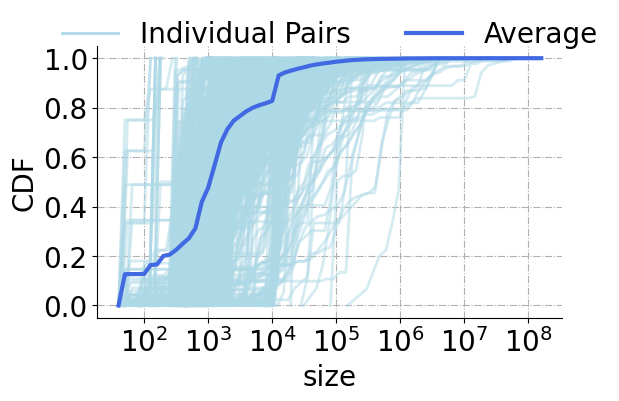

In [80]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4))
plt.subplots_adjust(bottom=0.2)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(2, 9, 1))
ax.set_xticklabels(["$10^%d$" % i for i in np.arange(2, 9, 1)], fontsize=20)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_yticklabels(["%.1f"% i for i in np.arange(0, 1.1, 0.2)], fontsize=20)
ax.set_ylabel('CDF', fontsize=20)
ax.set_xlabel('size', fontsize=20)
plt.grid(linestyle='-.')

size = np.log10(pairdata[freqpairs[0]]['size'].values)
bins = np.arange(np.min(size) - 0.1, np.max(size) + 0.1, 0.1)
counts, bins = np.histogram(size, bins)
cdf = np.cumsum(counts) / np.cumsum(counts)[-1]
plt.plot(bins[1:], cdf, linewidth=2, color='LightBlue', alpha=1.0, label='Individual Pairs')
for i in range(1, pairs):
    size = np.log10(pairdata[freqpairs[i]]['size'].values)
    bins = np.arange(np.min(size) - 0.1, np.max(size) + 0.1, 0.1)
    counts, bins = np.histogram(size, bins)
    cdf = np.cumsum(counts) / np.cumsum(counts)[-1]
    plt.plot(bins[1:], cdf, linewidth=2, color='LightBlue', alpha=0.5)

all_size = []
for i in range(pairs):
    all_size.extend(list(pairdata[freqpairs[i]]['size'].values))
all_size = np.log10(all_size)
bins = np.arange(np.min(all_size) - 0.1, np.max(all_size) + 0.1, 0.1)
counts, bins = np.histogram(all_size, bins)
cdf = np.cumsum(counts) / np.cumsum(counts)[-1]
plt.plot(bins[1:], cdf, linewidth=3, color='RoyalBlue', label='Average')
plt.legend(fontsize=20, frameon=False, loc=(-0.1, 0.95), ncol=2)
